# implement and test hyperparameter optimization for XGBoost

In [1]:
import numpy as np
from astropy.table import Table

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline 

# read in survey data

In [4]:
survey = Table.read('ejflooddata_combined.hdf5')

In [5]:
country = 'South Korea'
expsoure = 'rain'
city0 = survey[(survey['country'] == country) & (survey['res_length'] > 3.) & (survey['gender'] < 3.)]

## compile training data

In [6]:
city0.columns

<TableColumns names=('﻿ResponseId','experience_rain','experience_coast','experience_river','experience_wind','experience_heat','experience_drought','experience_fire','experience_quake','relocation','gov_aid','self_vul','discrimination','education','income_USD','income_USD.mask','age','gender','queer','disability','res_length','language','language.mask','born','born.mask','races','relocation.recoded','education.recoded','country')>

In [7]:
# properites of the population
col_pop = ['self_vul', 'discrimination', 'education.recoded', 'income_USD', 'age', 'gender', 'queer', 'disability', 'language']
#col_pop = ['discrimination', 'education.recoded', 'income_USD', 'age', 'gender', 'queer', 'disability', 'language']

X = np.array([city0[col] for col in col_pop]).T
Y = np.array(city0['experience_rain']) # exposure to rain 

In [8]:
# weights for data
W = np.zeros(len(Y))
for _y in np.unique(Y): 
    is_y = (Y.flatten() == _y)
    W[is_y] = 1/np.sum(is_y)
W *= len(W)/np.sum(W)

# train XGBoost

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, 
                                                                     test_size=0.2, random_state=42)

In [11]:
ntrial = 1000
models = [] 
scores = []
for i in range(ntrial): 
    dep = np.random.randint(1, 5)
    lr = 10**np.random.uniform(low=-2, high=0)
    nround = np.random.randint(50, 300)

    xgb_model = xgb.XGBClassifier(
        n_estimators=nround,
        max_depth=dep,
        learning_rate=lr,
        importance_type='gain', 
        eval_metric='logloss')

    # Train the model
    xgb_model.fit(X_train, y_train-1, sample_weight=w_train)
    
    y_pred = xgb_model.predict(X_test) + 1
    test_score = np.sum((y_pred - y_test)**2)
    
    #print('%i, %.3f, %i, %.3f' % (dep, lr, nround, test_score))
    models.append(xgb_model)
    scores.append(test_score)

In [12]:
best_models = [models[i] for i in np.argsort(scores)[:5]]
print([scores[i] for i in np.argsort(scores)[:5]])

[91, 92, 93, 95, 95]


(0.0, 6.0)

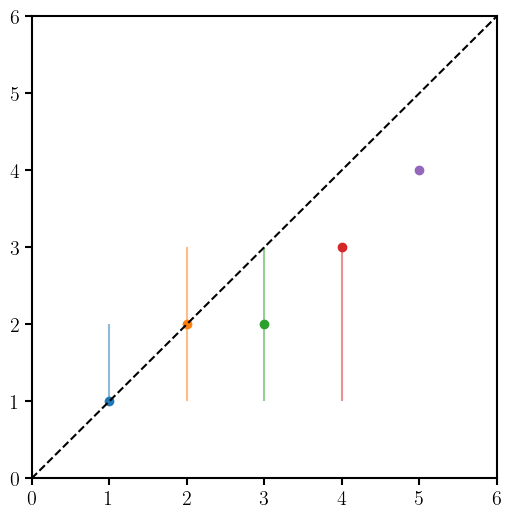

In [13]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

y_preds = [] 
for best_model in best_models: 
    y_pred = best_model.predict(X_test) + 1
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

for u in np.arange(1,6):
    is_u = (y_test == u).flatten()
    if np.sum(is_u) > 0: 
        q0, q1, q2 = np.quantile(np.concatenate(y_preds[:,is_u]), [0.16, 0.5, 0.84])
        sub.errorbar([u], [q1], [[q1-q0], [q2-q1]], color='C%i' % (u-1), alpha=0.5)
        sub.scatter([u], [q1], color='C%i' % (u-1))
sub.plot([0., 10.], [0., 10.], color='k', linestyle='--')
sub.set_xlim(0., 6)
sub.set_ylim(0., 6)

(0.0, 0.31823454666137696)

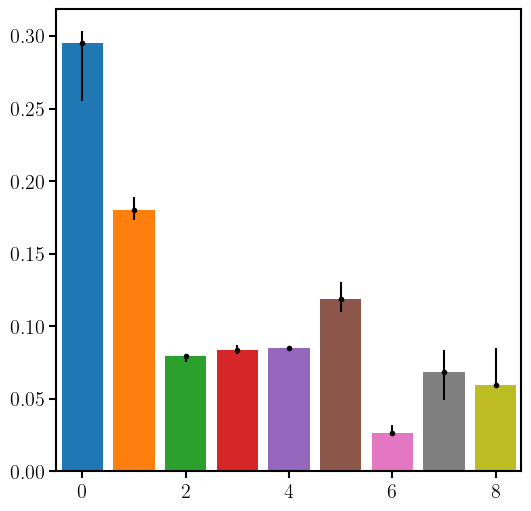

In [14]:
#feature_names = ['vulnerability', 'discrimination', 'education', 'income', 
#                              'age', 'gender', 'queer', 'disability', 'language']#, 'relocation']

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

feature_importances = []
for best_model in best_models: 
    feature_importances.append(best_model.feature_importances_)
feature_importances = np.array(feature_importances)    

for i in range(feature_importances.shape[1]): 
    q0, q1, q2 = np.quantile(feature_importances[:,i], (0.16, 0.5, 0.84))
    sub.errorbar([i], [q1], [[q2-q1], [q1-q0]], fmt='.k', zorder=20)
    #sub.scatter([i], [q1], color='C%i' % i)
    sub.bar([i], [q1], color='C%i' % i)
    
#for ii, name, imp in zip(np.arange(len(feature_names)), feature_names, feature_importances):

sub.set_xlim(-0.5, feature_importances.shape[1]-0.5)
sub.set_ylim(0., None)